<a href="https://colab.research.google.com/github/ananyaarya02/DoodleDoctor/blob/main/DoodleDoctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from shapely.geometry import Polygon
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from scipy.interpolate import splprep, splev

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


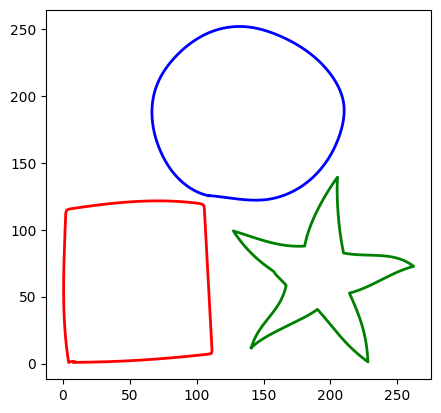

In [29]:
import numpy as np
import matplotlib.pyplot as plt

colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(path_XYs):
    fig, ax = plt.subplots()
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Path to your CSV file
file_path = '/content/drive/MyDrive/ARQ/isolated.csv'

# Read the CSV and plot
path_XYs = read_csv(file_path)
plot(path_XYs)

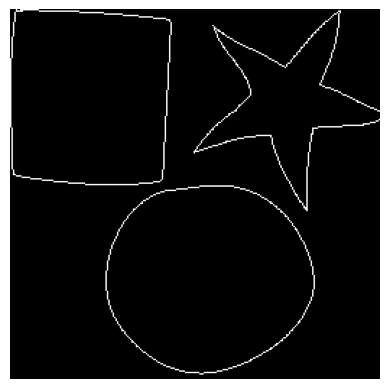

In [30]:

def apply_grayscale_to_paths(path_XYs):
    img = np.zeros((256, 256), dtype=np.uint8)
    for XYs in path_XYs:
        for XY in XYs:
            for k in range(len(XY) - 1):
                cv2.line(img, tuple(XY[k].astype(int)), tuple(XY[k + 1].astype(int)), 255, 1)
    plt.imshow(img, cmap="gray"), plt.axis("off")
    plt.show()


apply_grayscale_to_paths(path_XYs)

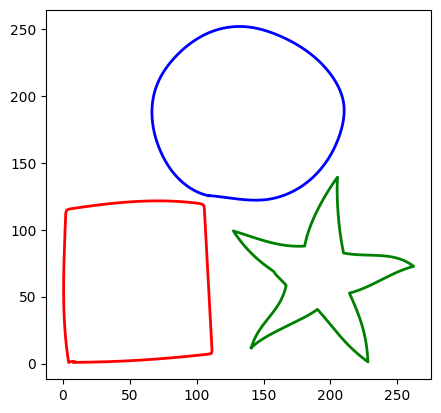

In [ ]:


colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(path_XYs):
    fig, ax = plt.subplots()
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()


file_path = '/content/drive/MyDrive/problems/isolated.csv'

path_XYs = read_csv(file_path)
plot(path_XYs)

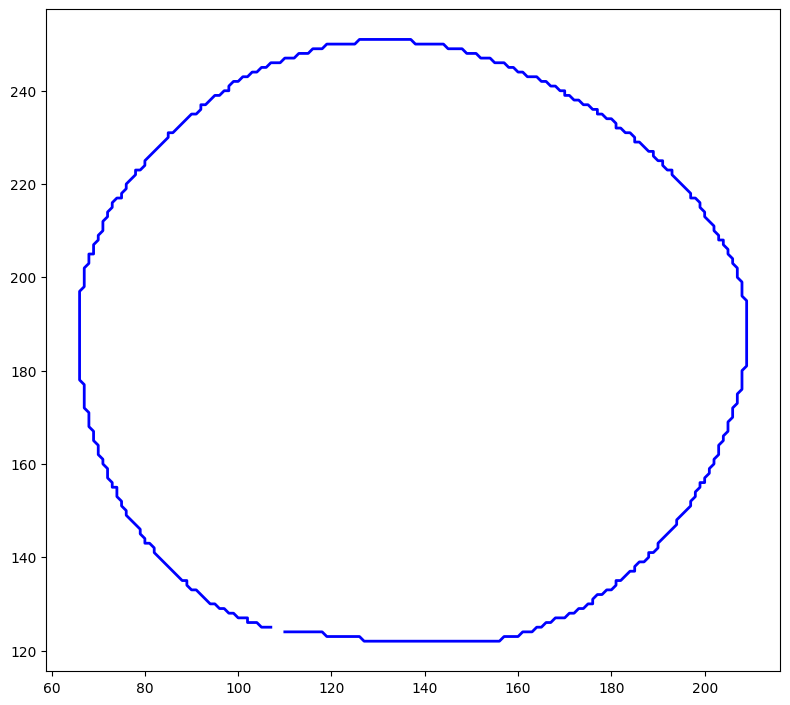

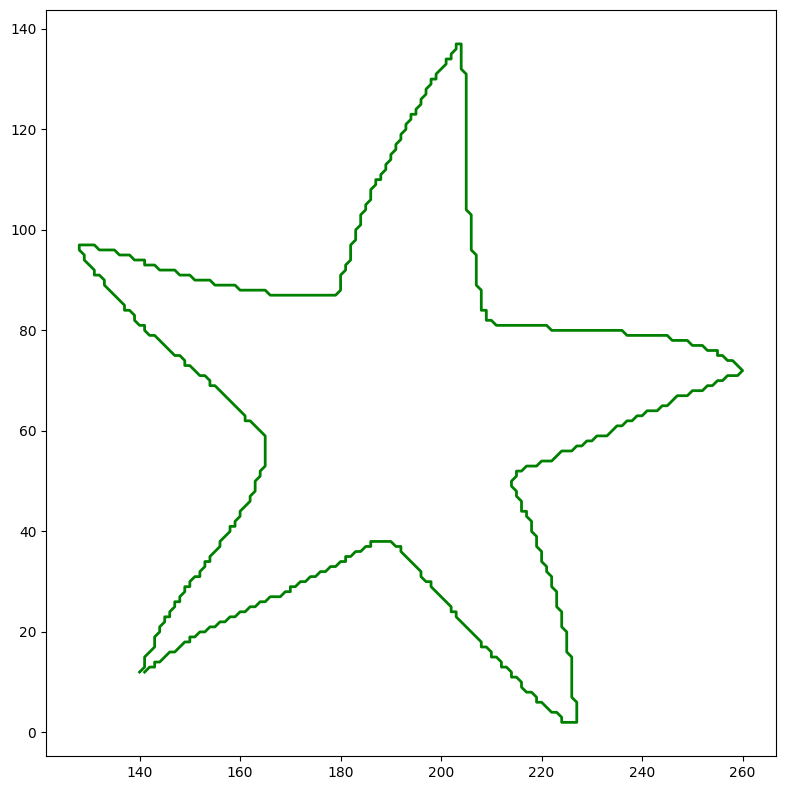

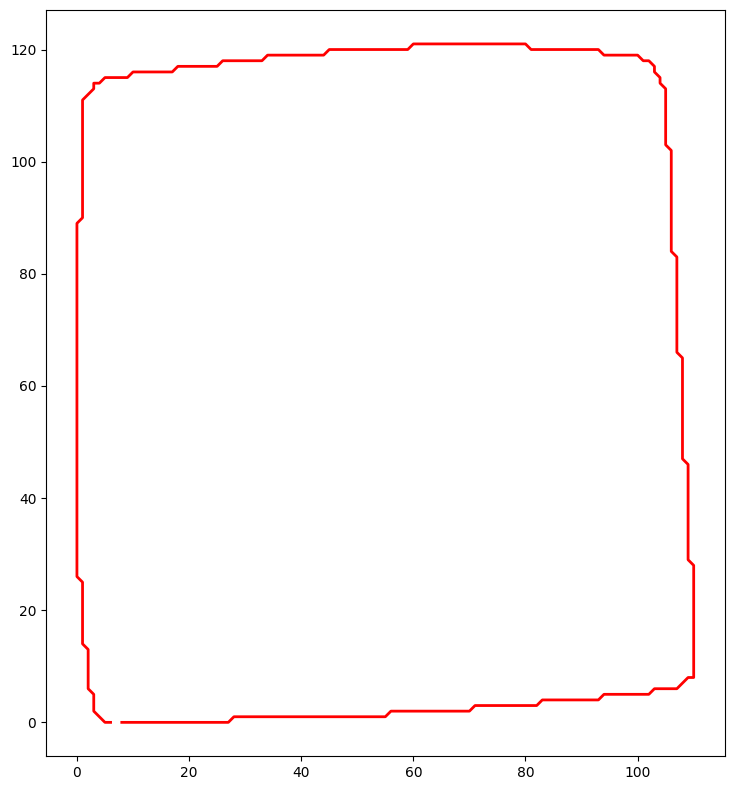

In [ ]:


csv_path = '/content/drive/MyDrive/problems/isolated.csv'
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def separate_layers(path_XYs):
    layers = []
    for XYs in path_XYs:
        layer = []
        for XY in XYs:
            contour = np.array(XY, dtype=np.int32)
            layer.append(contour)
        layers.append(layer)
    return layers

def identify_shapes(layers):
    shapes = []
    for layer in layers:
        shape = []
        for contour in layer:
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w)/h
            if area > 100 and aspect_ratio > 0.5:
                shape.append('rectangle')
            elif area > 100 and aspect_ratio < 0.5:
                shape.append('ellipse')
            else:
                shape.append('polygon')
        shapes.append(shape)
    return shapes

def check_symmetry(contour):
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments)
    if hu_moments[0] < 0.05:
        return True
    else:
        return False

def regularize_shape(contour):
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def smooth_curve(contour):
    x, y = contour.T
    x_smooth = gaussian_filter1d(x, 2)
    y_smooth = gaussian_filter1d(y, 2)
    contour_smooth = np.array([x_smooth, y_smooth]).T
    return contour_smooth

def process_layer(layer):
    processed_layer = []
    for contour in layer:
        if check_symmetry(contour):
            contour = regularize_shape(contour)
        contour = smooth_curve(contour)
        processed_layer.append(contour)
    return processed_layer

def process_layers(layers):
    processed_layers = []
    for layer in layers:
        processed_layer = process_layer(layer)
        processed_layers.append(processed_layer)
    return processed_layers

path_XYs = read_csv(csv_path)
layers = separate_layers(path_XYs)
shapes = identify_shapes(layers)
processed_layers = process_layers(layers)

# Plot the processed layers
for i, layer in enumerate(processed_layers):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    c = colours[i % len(colours)]
    for contour in layer:
        ax.plot(contour[:, 0], contour[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

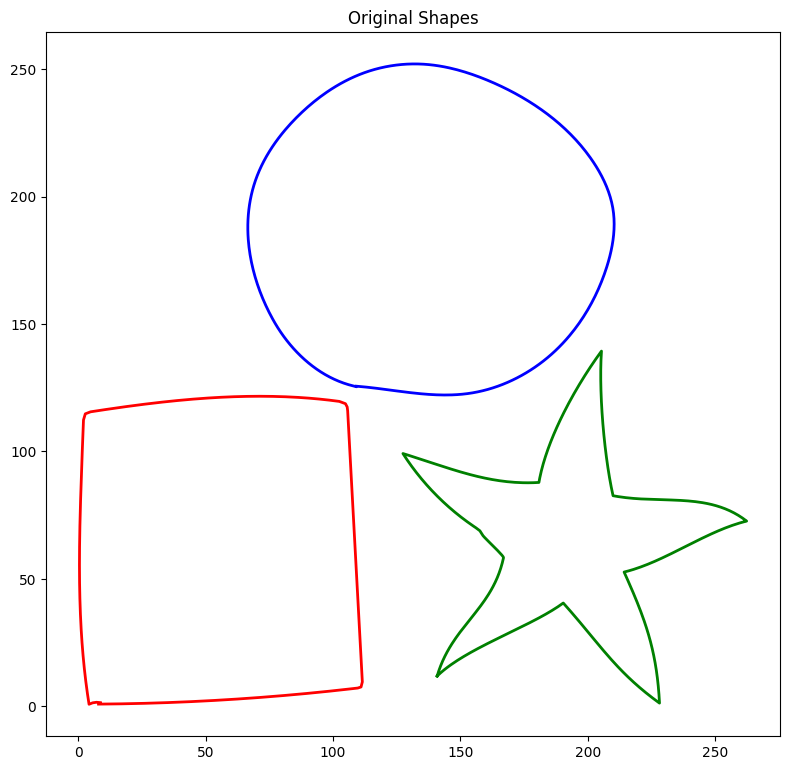

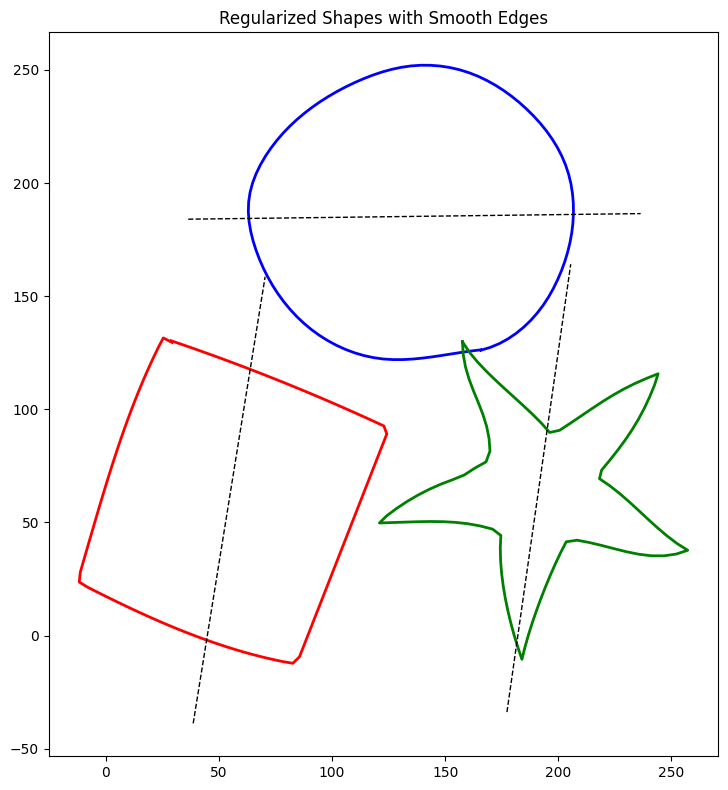

In [ ]:


csv_path = '/content/drive/MyDrive/problems/isolated.csv'
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def compute_symmetry_axis(XYs):
    pca = PCA(n_components=2)
    pca.fit(XYs)
    return pca.components_[0]  # First principal component as symmetry axis

def reflect_shape(XYs, axis):
    axis = axis / np.linalg.norm(axis)  # Normalize axis
    centroid = np.mean(XYs, axis=0)
    reflected = XYs - 2 * np.outer(np.dot(XYs - centroid, axis), axis)
    return reflected

def smooth_shape(XYs):
    XYs = np.array(XYs)
    tck, u = splprep([XYs[:, 0], XYs[:, 1]], s=0)
    new_points = splev(np.linspace(0, 1, 100), tck)
    return np.vstack(new_points).T

def plot(paths_XYs, title, axes_of_symmetry=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
            if axes_of_symmetry:
                axis = axes_of_symmetry[i]
                centroid = np.mean(XY, axis=0)
                line_x = [centroid[0] - axis[0] * 100, centroid[0] + axis[0] * 100]
                line_y = [centroid[1] - axis[1] * 100, centroid[1] + axis[1] * 100]
                ax.plot(line_x, line_y, 'k--', linewidth=1)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

def process_shapes(path_XYs):
    processed_shapes = []
    symmetry_axes = []
    for XYs in path_XYs:
        for XY in XYs:
            symmetry_axis = compute_symmetry_axis(XY)
            reflected_shape = reflect_shape(XY, symmetry_axis)
            smoothed_shape = smooth_shape(reflected_shape)
            processed_shapes.append([smoothed_shape])
            symmetry_axes.append(symmetry_axis)  # Store the symmetry axis
    return processed_shapes, symmetry_axes

# Read CSV and extract shapes
path_XYs = read_csv(csv_path)

# Plot original shapes
plot(path_XYs, "Original Shapes")

# Process shapes to find symmetry, reflect, and smooth
processed_shapes, symmetry_axes = process_shapes(path_XYs)

# Plot regularized shapes with smooth edges and symmetry axes
plot(processed_shapes, "Regularized Shapes with Smooth Edges", axes_of_symmetry=symmetry_axes)

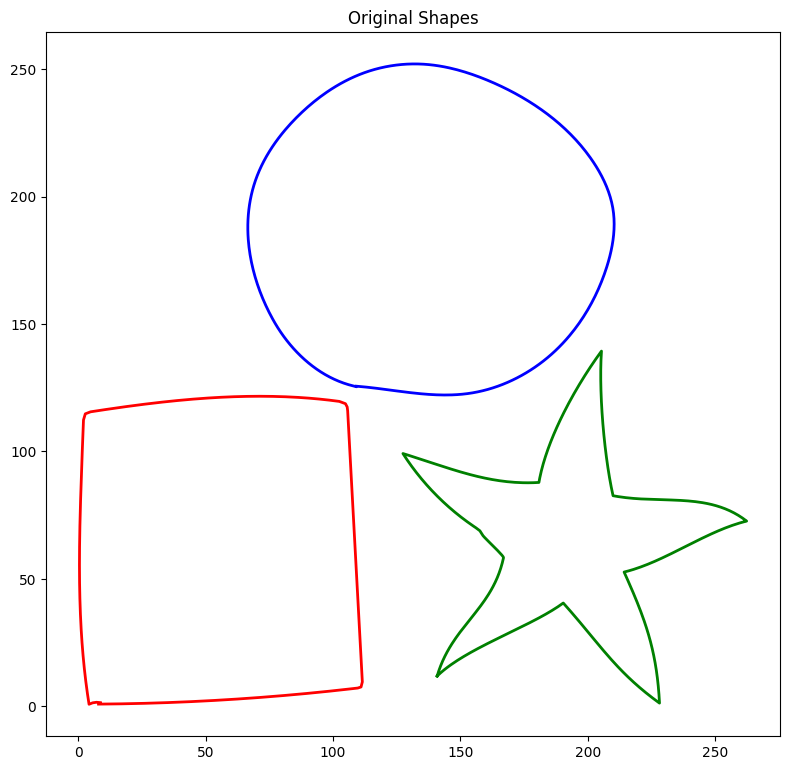

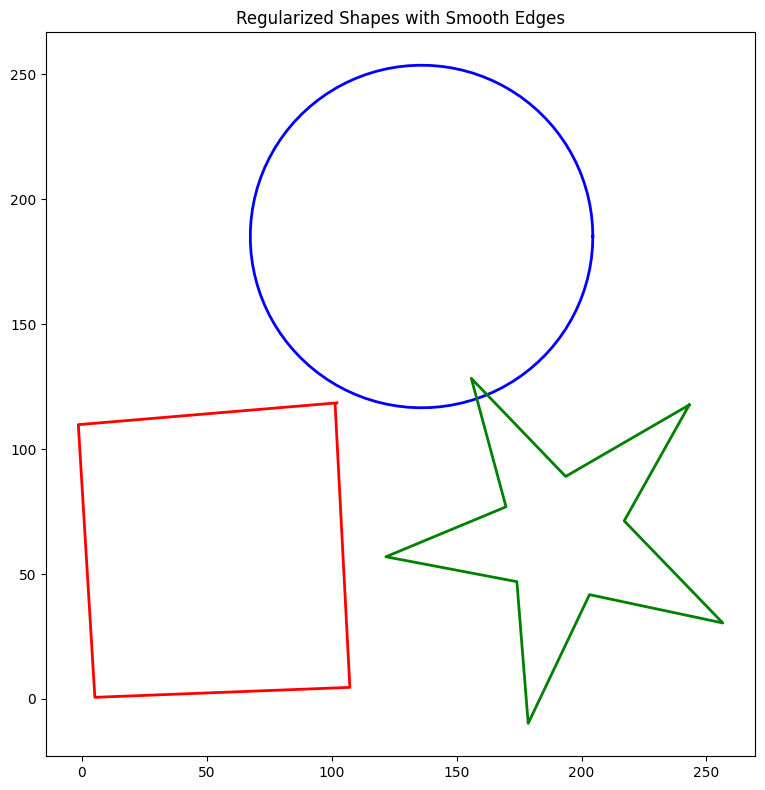

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from scipy.optimize import leastsq
from shapely.geometry import Polygon, Point

csv_path = '/content/drive/MyDrive/problems/isolated.csv'
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title="Shapes"):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

def find_symmetry_axes(XYs):
    pca = PCA(n_components=2)
    pca.fit(XYs)
    return pca.components_

def reflect_shape(XYs, axis):
    axis = axis / np.linalg.norm(axis)
    centroid = np.mean(XYs, axis=0)
    reflection = XYs - centroid
    reflection = reflection - 2 * np.outer(np.dot(reflection, axis), axis)
    reflection = reflection + centroid
    return reflection

def douglas_peucker(points, epsilon):
    if len(points) < 3:
        return points

    start, end = points[0], points[-1]
    line_vec = end - start
    line_vec = line_vec / np.linalg.norm(line_vec)
    distances = np.abs(np.cross(points - start, end - start) / np.linalg.norm(end - start))

    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx]

    if max_dist > epsilon:
        results1 = douglas_peucker(points[:max_dist_idx+1], epsilon)
        results2 = douglas_peucker(points[max_dist_idx:], epsilon)
        return np.vstack((results1[:-1], results2))
    else:
        return np.vstack((start, end))

def fit_circle(XYs):
    def calc_R(xc, yc):
        return np.sqrt((XYs[:, 0] - xc)**2 + (XYs[:, 1] - yc)**2)

    def f_2b(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(XYs, axis=0)
    center, ier = leastsq(f_2b, center_estimate)
    Ri = calc_R(*center)
    R = Ri.mean()
    circle = np.array([
        [center[0] + R * np.cos(theta), center[1] + R * np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, num=100)
    ])
    return circle

def fit_polygon(XYs, sides=4):
    hull = ConvexHull(XYs)
    vertices = XYs[hull.vertices]
    centroid = np.mean(vertices, axis=0)
    angles = np.arctan2(vertices[:, 1] - centroid[1], vertices[:, 0] - centroid[0])
    angles_sorted_idx = np.argsort(angles)
    vertices = vertices[angles_sorted_idx]

    def regular_polygon_vertex(angle, radius):
        return [centroid[0] + radius * np.cos(angle), centroid[1] + radius * np.sin(angle)]

    radius = np.mean(np.linalg.norm(vertices - centroid, axis=1))
    angles_regular = np.linspace(0, 2 * np.pi, sides, endpoint=False)
    regular_polygon = np.array([regular_polygon_vertex(angle, radius) for angle in angles_regular])
    return regular_polygon

def smooth_shape(XYs, epsilon=8.0):
    XYs = np.array(XYs)
    simplified = douglas_peucker(XYs, epsilon)

    if len(simplified) >= 12:
        smoothed = fit_circle(simplified)
    elif len(simplified) == 4:
        smoothed = fit_polygon(simplified, sides=4)
    else:
        smoothed = simplified
    return smoothed

def identify_shapes(XYs):
    db = DBSCAN(eps=10, min_samples=10).fit(XYs)
    labels = db.labels_
    unique_labels = set(labels)
    shapes = []
    for k in unique_labels:
        if k != -1:
            class_member_mask = (labels == k)
            XY = XYs[class_member_mask]
            shapes.append(XY)
    return shapes

def process_shapes(path_XYs):
    processed_shapes = []
    symmetry_axes = []
    for XYs in path_XYs:
        for XY in XYs:
            shapes = identify_shapes(XY)
            for shape in shapes:
                if len(shape) < 3:
                    continue
                axes = find_symmetry_axes(shape)
                reflected_shape = shape.copy()
                for axis in axes:
                    reflected_shape = reflect_shape(reflected_shape, axis)
                smoothed_shape = smooth_shape(reflected_shape)
                processed_shapes.append([smoothed_shape])
                symmetry_axes.append(axes)
    return processed_shapes, symmetry_axes

def save_to_csv(shapes, file_path):
    with open(file_path, 'w') as f:
        for i, shape in enumerate(shapes):
            for j, point in enumerate(shape[0]):
                f.write(f"{i},{j},{point[0]},{point[1]}\n")

# Read CSV and extract shapes
path_XYs = read_csv(csv_path)

# Plot original shapes
plot(path_XYs, "Original Shapes")

# Process shapes to find symmetries, reflect, and smooth
processed_shapes, symmetry_axes = process_shapes(path_XYs)

# Plot regularized shapes with smooth edges and symmetry axes
plot(processed_shapes, "Regularized Shapes with Smooth Edges")

# Save processed shapes to CSV
output_csv_path = '/content/drive/MyDrive/problems/isolated.csv'
save_to_csv(processed_shapes, output_csv_path)